# Mod 4 Project - Atlanta Housing data

This notebook uses house price data from Zillow.com.


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


#for modeling
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('zillow_data.csv')
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
df.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

# Step 2: Reshape from Wide to Long Format & Data Preprocessing

In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
dfm = melt_data(df)
display(dfm.head())
dfm.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Month         datetime64[ns]
MeanValue     float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


### Step 2b: Selecting a region for investigation

Region = Atlanta, Georgia

In [6]:
ATL = dfm[(dfm.Metro == 'Atlanta')
          & (dfm.CountyName.isin(['Fulton','Dekalb']))].copy()
ATL.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,1996-04-01,97100.0
254,70808,30022,Johns Creek,GA,Atlanta,Fulton,255,1996-04-01,206900.0
305,70791,30004,Milton,GA,Atlanta,Fulton,306,1996-04-01,184800.0
492,70839,30058,Lithonia,GA,Atlanta,Dekalb,493,1996-04-01,84600.0
557,70854,30075,Roswell,GA,Atlanta,Fulton,558,1996-04-01,189500.0


In [7]:
# Remove columns which are not helpful for data analysis
ATL.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis=1, inplace=True)
ATL.reset_index(drop=True, inplace=True)
ATL.head()

,RegionName,Month,MeanValue
0,30331,1996-04-01,97100.0
1,30022,1996-04-01,206900.0
2,30004,1996-04-01,184800.0
3,30058,1996-04-01,84600.0
4,30075,1996-04-01,189500.0


In [8]:
# See if any zipcodes are lacking observations
print(len(ATL.RegionName.unique()))
ATL.RegionName.value_counts()[-7:]

41


30058    265
30034    265
30002    265
30022    265
30079     58
30032     58
30288     52
Name: RegionName, dtype: int64

In [9]:
# Removing zip codes lacking 265 observations
ATL = ATL[~ATL.RegionName.isin([30079,30032,30288])]

# Step 3: EDA and Visualization

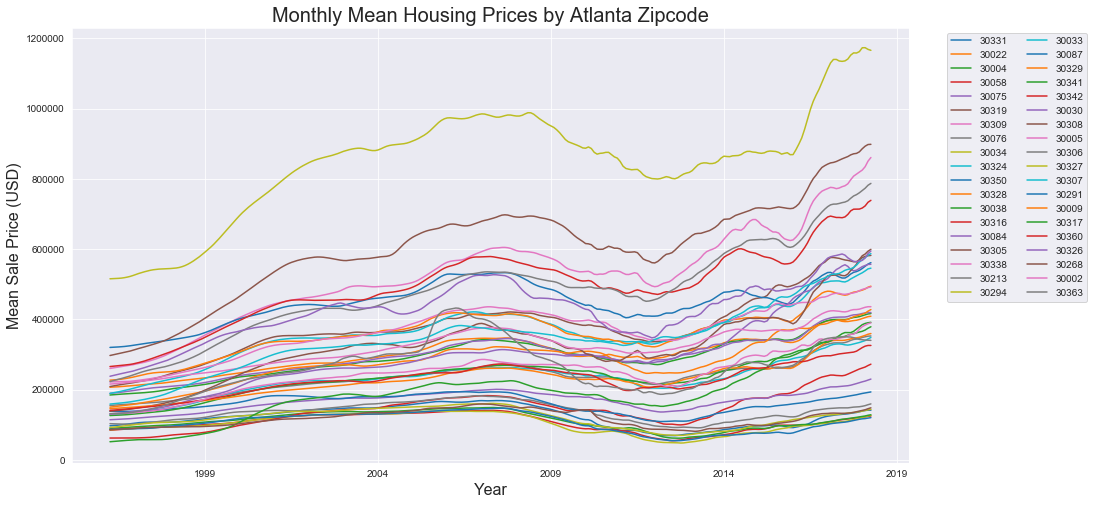

In [10]:
for zipcode in ATL.RegionName.unique():
    temp_df = ATL[ATL.RegionName == zipcode].set_index('Month')
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by Atlanta Zipcode", fontsize=20);

Wonderful! It appears that each of the Atlanta zipcodes is capable of being plotted without throwing any errors.

#### Removing potentially confounding data

Looking at the graph above and thinking about recent history, we know that the housing crash of 2008 is the culprit behind the dip in housing price in the middle of our graph. Because we want to make business decisions based on post-crash trends. Therefore, we will build our models using only the data gathered after 2010 (2011-present) since this was when the housing market bottomed out. 

In [11]:
ATL2 = ATL[ATL.Month >= '2012']

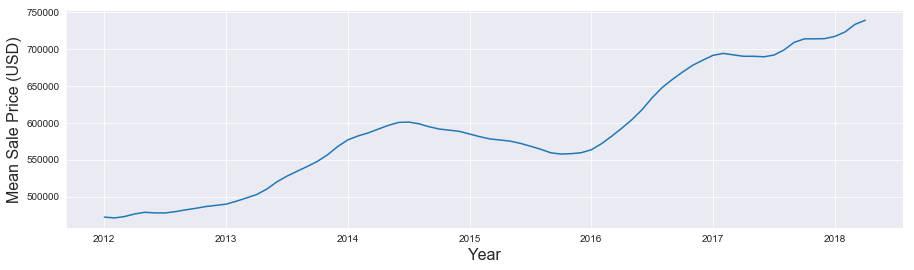

In [12]:
# Plot an example zipcode, to test outcome
temp_df = ATL2[ATL2.RegionName == 30342].set_index('Month')
temp_df['MeanValue'].plot(figsize=(15,4), label=30342)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16);

# Step 4: ARIMA Modeling

Region: Atlanta

Best = Highest ROI with the lowest volatility since 2010 (after housing crash)

In [13]:
# Make a dictionary for each zipcode
atlanta = {}
for zipcode in ATL2.RegionName.unique():
    temp = ATL2[ATL2.RegionName == zipcode].set_index('Month')
    temp.drop('RegionName', axis=1, inplace=True)
    atlanta[zipcode] = temp

In [14]:
# Log transform the values
ATL_log ={}
for zipcode in atlanta.keys():
    ATL_log[zipcode] = np.log(atlanta[zipcode])

In [15]:
# Differencing the log-transformed values
ATL_log_diff = {}
for key in list(atlanta.keys()):
    ATL_log_diff[key] = ATL_log[key].diff(periods=12).dropna()

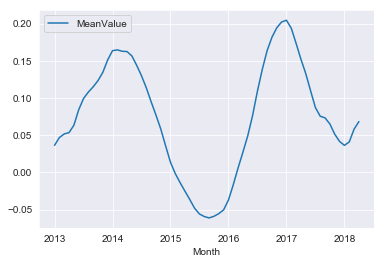

In [16]:
ATL_log_diff[30342].plot();

In [17]:
# Define a function that will check for the stationarity of a time series
def stationarity_check(TS, column_name, rolling_window=7):    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name]) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    pass

In [18]:
# Define a function to decompose a time series, in order to detect
# trends and seasonality, and allow for examining the residuals
def df_decompose(df):
    # Gather the trend, seasonality and noise of decomposed object
    trend = sd(df).trend
    seasonal = sd(df).seasonal
    residual = sd(df).resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.title(f"Decomposition for {df}")
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    
    return residual.dropna()

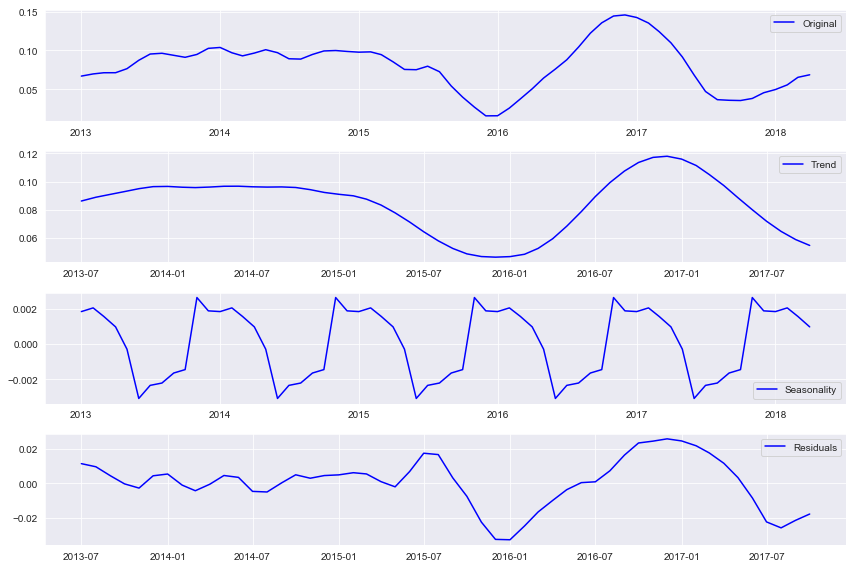

In [19]:
decomp30324 = df_decompose(ATL_log_diff[30324])

Looking at the y-axis of the seasonality plot, it appears that there is **very** little seasonality. So little, in fact, that we can most likely assume that seasonality is not a feature of our data.

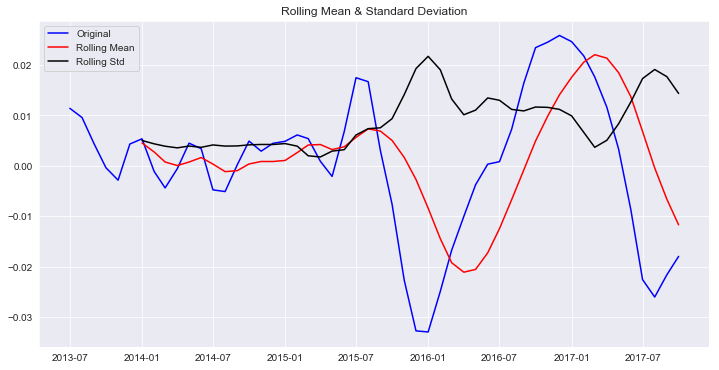

Results of Dickey-Fuller Test:
Test Statistic                 -3.785198
p-value                         0.003062
#Lags Used                      8.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [20]:
stationarity_check(decomp30324,'MeanValue')

**Our data appears to be stationary!**

### Let's try using sARIMAX without seasonality

In [21]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

In [22]:
def find_best_pdq(df, label, pdq):
    """
    Input a dataframe and lists of potential pdq & pdqs values
    Finds combination of pdq/pdqs values that returns lowest AIC
    Returns tuple of label, pdq, and pdqs
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    results = []
    for params in pdq:
        try:
            model = SARIMAX(endog=df, order=params,
#                                 seasonal_order=seas_params,
                            enforce_stationarity=False, enforce_invertibility=False)
            AIC = model.fit().aic
#             print(f'ARIMA{params}x{seas_params}12 - AIC: {AIC}')
            results.append([params, AIC])
        except:
            continue

    results.sort(key=lambda x: x[-1])
    result_pdq = results[0][0]
#     print(f'Lowest AIC: ARIMA{result_pdq} - AIC: {results[0][1]}')
    return (label, result_pdq)

In [23]:
pdq30342 = find_best_pdq(ATL_log[30342], 30342, pdq)

In [ ]:
pdq30342

(30342, (2, 0, 1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              MeanValue   No. Observations:                   76
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 322.830
Date:                Wed, 31 Jul 2019   AIC                           -637.661
Time:                        14:25:40   BIC                           -628.444
Sample:                    01-01-2012   HQIC                          -633.984
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8074      0.080     22.630      0.000       1.651       1.964
ar.L2         -0.8073      0.080    -10.103      0.000      -0.964      -0.651
ma.L1          0.5117      0.155      3.293      0.001       0.207       0.816
sigma2      9.446e-06   1.82e-06      5.183      0.000    5.87e-06     1.3e-05
===================================================================================
Ljung-Box (Q):                       41.68   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.40   Prob(JB):                         0.46
Heteroskedasticity (H):               1.69   Skew:                            -0.30
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

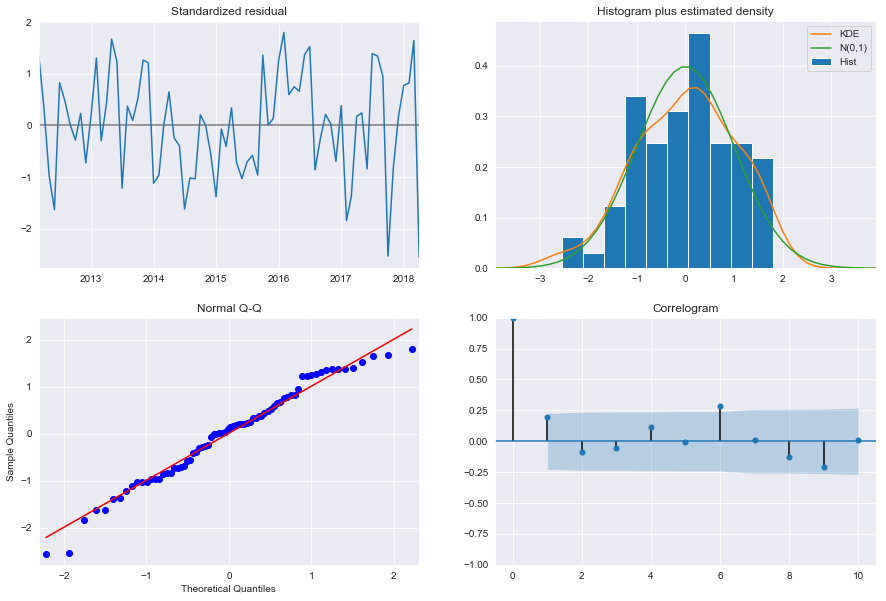

In [ ]:
# plug the optimal parameter values into a new SARIMAX model.
mod_SARIMAX = SARIMAX(endog=ATL_log[30342], order=pdq30342[1],
                            enforce_stationarity=False, enforce_invertibility=False)

# Fit the model and print results
res_SARIMAX = mod_SARIMAX.fit()
display(res_SARIMAX.summary())
res_SARIMAX.plot_diagnostics(figsize=(15,10));

In [ ]:
# Get predictions starting from 2016 and calculate confidence intervals.
prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
pred_conf = prediction.conf_int()

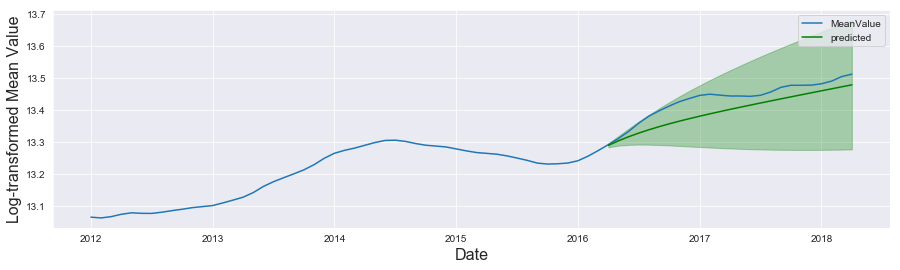

In [ ]:
# Plot observed values
ATL_log[30342]['2012':].plot(label='observed')

# Plot predicted values
prediction.predicted_mean.plot(figsize=(15,4),color='g', label='predicted')

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Log-transformed Mean Value', fontsize=16)
plt.legend();

In [ ]:
# Get the Real and predicted values
ATL30342_truth = ATL_log[30342]['2016-04':]
ATL30342_forecasted = prediction.predicted_mean

# Compute the mean square error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(ATL30342_truth, ATL30342_forecasted))
print(f'The Root Mean Squared Error of our forecasts is {round(rmse, 3)}')

The Root Mean Squared Error of our forecasts is 0.04


### Now iterate through all selected zipcodes

In [ ]:
def plot_predictions(df, label, prediction, pred_conf, best_pdq):
    """Inputs: dataframe, zipcode label, predictions, prediction confidence
    intervals, and optimal (p,d,q) parameters
    -------------------
    This function plots a time series, a predicted mean line, and prediction
    confidence intervals.
    """
    # Plot observed values
    np.exp(df['2012':]).plot(label='observed')
    
    # Plot predicted values
    pred_price = np.exp(prediction.predicted_mean)
    pred_price.plot(figsize=(15,4),color='g', label='predicted')
    
    # Plot the range for confidence intervals
    pred_conf_usd = np.exp(pred_conf)
    plt.fill_between(pred_conf_usd.index,
                    pred_conf_usd.iloc[:, 0],
                    pred_conf_usd.iloc[:, 1], color='g', alpha=.3)
    
    # Set axes labels
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.title(f"{label} Zipcode; pdq={best_pdq}", fontsize=16)
    plt.legend(loc='best', fontsize=14)
    plt.show();


def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = ((final_value - investment) / investment)
    return roi


def confidence_score(pred_conf):
    """This function takes in a prediction's confidence interval
    and calculates the difference between the upper and lower bounds at the
    greatest X value as a proportion of the upper bound maximum. The purpose 
    is to provide a metric by which to compare model according to their variability.
    A model with more uncertainty will have a lower confidence score.
    -----------------------
    Since I pretty much made this up, I'm calling it the Parker Confidence Score (PCS)."""
    pred_conf_usd = np.exp(pred_conf)    #reversing log-transformation
    conf_score = 1 - ((pred_conf_usd['upper MeanValue'][-1]
                       - pred_conf_usd['lower MeanValue'][-1])
                      / pred_conf_usd['upper MeanValue'][-1])
    return conf_score


def make_best_Arima_model(df, label, pdq):
    """
    Inputs: a dataframe, the zipcode label, and list of (p,d,q) combinations.
    ------------------------
    The function calculates the optimal (p,d,q), then creates a dynamic SARIMAX
    model with those paramters. The model then makes predictions and, if the lower
    bound of the confidence interval is greater than the prediction starting point
    (i.e. guarantee of profit), the model calcules RMSE, ROI, and a Confidence
    Score. 
    ------------------------
    Returns: label, optimal (p,d,q) parameters, SARIMAX model  object, RMSE,
    ROI, and Confidence Score
    """
    import warnings
    warnings.filterwarnings('ignore')
    
    result_pdq = find_best_pdq(df, label, pdq)
    
    # plug the optimal parameter values into a new SARIMAX model.
    mod_SARIMAX = SARIMAX(endog=df, order=result_pdq[1],
                                enforce_stationarity=False, enforce_invertibility=False)
    
    # Fit the model and print results
    res_SARIMAX = mod_SARIMAX.fit()
    
    # Get predictions starting from 2016 and calculate confidence intervals.
    prediction = res_SARIMAX.get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
    pred_conf = prediction.conf_int()
    rmse = 0
    roi = 0
    conf_score = 0
    if pred_conf['lower MeanValue'][-1] > pred_conf['lower MeanValue'][0]:
        print("\n\nZipcode:", label)
        
        # Get the Real and predicted values
        df_truth = np.exp(df['2016-04':])
        df_forecasted = np.exp(prediction.predicted_mean)
        
        # Compute the mean square error & volatility
        rmse = np.sqrt(mean_squared_error(df_truth, df_forecasted))
        print(f'Root Mean Squared Error of forecast: {round(rmse, 3)}')
        conf_score = np.round(confidence_score(pred_conf), 4)
        print(f'Parker Confidence Score: {conf_score}')
        
        #Expected 2-year return on investment
        roi = np.round(expected_roi(df_forecasted[0], df_forecasted[-1]),4)
        print(f"Model 2-yr expected ROI rate: {roi*100}%")
        
        # Plot observed & predicted values with confidence interval
        plot_predictions(df, label, prediction, pred_conf, result_pdq[1]);
    
    return label, result_pdq[1], res_SARIMAX, rmse, roi, conf_score

#### WARNING:

The next cell may take several minutes to run.



Zipcode: 30004
Root Mean Squared Error of forecast: 8838.528
Parker Confidence Score: 0.7923
Model 2-yr expected ROI rate: 17.53%


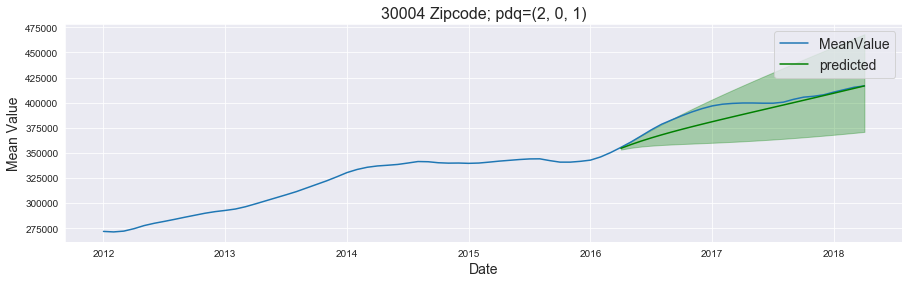



Zipcode: 30058
Root Mean Squared Error of forecast: 930.948
Parker Confidence Score: 0.6549
Model 2-yr expected ROI rate: 26.900000000000002%


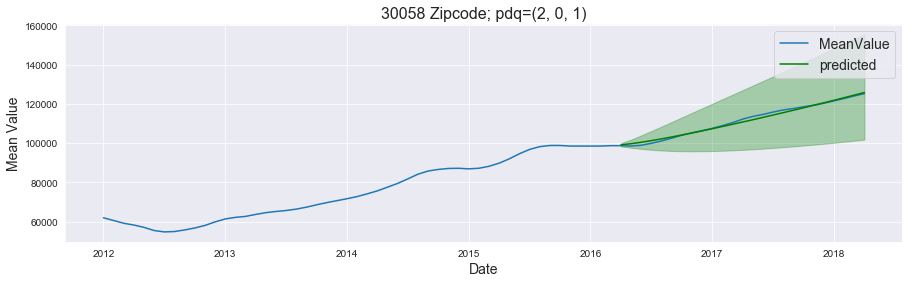



Zipcode: 30319
Root Mean Squared Error of forecast: 17569.948
Parker Confidence Score: 0.8472
Model 2-yr expected ROI rate: 19.34%


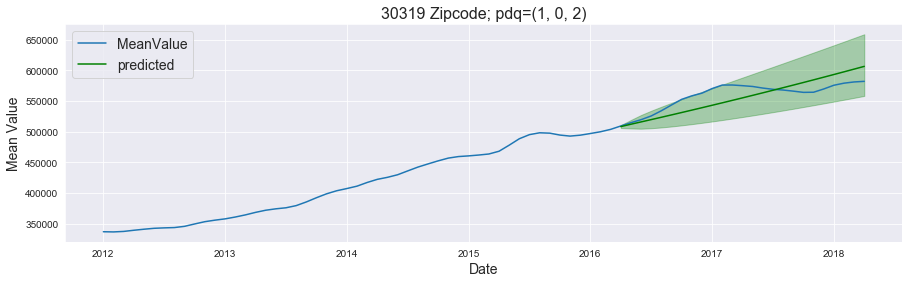

In [ ]:
ATL_arima_models = []
for zipcode in list(ATL_log.keys())[:]:
    model = make_best_Arima_model(ATL_log[zipcode], zipcode, pdq)
    ATL_arima_models.append(model)

In [ ]:
# Sort the output according to highest model confidence score
sorted_list = sorted(ATL_arima_models, key=lambda x: (x[-1], x[-2]), reverse=True)
for x in sorted_list:
    print(f"Zipcode:\t{x[0]}\nRMSE:\t\t{x[3]}\nROI:\t\t{x[-2]}\nConf. Score:\t{x[-1]}\n")

In [ ]:
# Filtering for models with confidence score > .8
best_conf = []
for x in sorted_list:
    if x[-1] > .8:
        best_conf.append(x)

# From these models, select the top five ROI
top_five = sorted(best_conf, key=lambda x: x[-2], reverse=True)[:5]
for x in top_five:
    print(f"Zipcode:\t{x[0]}\nRMSE:\t\t${round(x[3],2)}\nROI:\t\t{x[-2]}\nConf. Score:\t{x[-1]}\n")

#### Now examine the model summaries, just to make sure there is nothing problematic occurring behind the scenes.

In [ ]:
for x in top_five:
    print(f'\nZipcode: \t{x[0]}')
    display(x[2].summary())
    x[2].plot_diagnostics(figsize=(15,10));

# Step 5: Interpreting Results

Before we can interpret the results, we must first view them. Let's print the relevant metrics and graph the top five "best" models.

In [ ]:
for x in top_five:
    print(f'Zipcode:\t\t\t\t{x[0]}')
    print(f'Root Mean Squared Error of forecast:\t{round(x[3], 3)}')
    print(f'Parker Confidence Score:\t\t\t{x[-1]}')
    print(f'Model 2-yr expected ROI rate:\t\t{x[-2]*100}%')
    prediction = x[2].get_prediction(start=pd.to_datetime('2016-04'), dynamic=True)
    pred_conf = prediction.conf_int()
    
    # Get the Real and predicted values
    df_truth = np.exp(ATL_log[x[0]]['2016-04':])
    df_forecasted = np.exp(prediction.predicted_mean)
    
    # Plot observed & predicted values with confidence interval
    plot_predictions(ATL_log[x[0]], x[0], prediction, pred_conf, x[1])

As you can see, all five models have a Parker Confidence Score (PCS) of at least .8. This suggests that our models for these zipcodes are quite accurate and will continue to be so further into the future than the best available models for other zipcodes. The purpose here was to cut down on risk caused by volatility. 

Furthermore, the root mean squared errors for all five are relatively low, with none greater than $20,000. 

Perhaps most importantly, the 2-year expected return on investment (ROI) rate for all five models ranges from .19-.35, a pretty nice profit!

### Looking to the Future

Now that we are satisfied with our models, let's look to the future and see what the next two years might bring.

In [ ]:
for x in top_five:
    print(f"Zipcode:\t{x[0]}")

    prediction = x[2].get_forecast(steps=24)
    pred_conf = prediction.conf_int()
    pr_con_exp = np.exp(pred_conf)
    
    # Get the Real and predicted values
    df_truth = np.exp(ATL_log[x[0]]['2012':])
    df_forecasted = np.exp(prediction.predicted_mean)
    
    # Calculate various ROI rates:
    minROI = np.round(expected_roi(df_forecasted[0], pr_con_exp['lower MeanValue'][-1]),4)
    maxROI = np.round(expected_roi(df_forecasted[0], pr_con_exp['upper MeanValue'][-1]),4)
    eROI = np.round(expected_roi(df_forecasted[0], df_forecasted[-1]),4)
    print(f'Minimum ROI:\t{minROI*100}%')
    print(f'Maximum ROI:\t{maxROI*100}%')
    print(f"Expected ROI:\t{eROI*100}%")
    
    # Plot observed & predicted values with confidence interval
    plot_predictions(ATL_log[x[0]], x[0], prediction, pred_conf, x[1])

As you can see from the data above, if you were to buy a house of mean value in each of these zip codes, you would most likely see a minimum 2-year return on investment of 7-21%, a maximum 2-year ROI of 27-48%, and an average 2-year ROI of 18-34%. That's pretty good. Therefore, I highly recommend purchasing real estate in the Atlanta zipcodes of 30317, 30030, 30341, 30087, and 30319 which correspond to the areas of Kirkwood, Decatur, Chamblee, Rockbridge, and Brookhaven, respectively.

<img src='ATL_top_five.png' width=80%>